In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint ,  solve_ivp
import datetime
import matplotlib.ticker as plticker

from sys import platform

if platform == "darwin":
    folder="/Users/sjha/Documents/Github/new_model_data/"  ## mac
if platform == "win32":
    folder="C:\\Users\\jhash\\Documents\\renders\\opto\\" ## windows

print(folder)

C:\Users\jhash\Documents\renders\opto\


In [2]:
g_y=1.24e6   ##Hz
omega_0=4.45e15 ##Hz
del_omega=1e8
omega_1=omega_0-del_omega ##Hz
ohm=1e6         ##Hz
g_z0=0
g_z1=(20*ohm)**0.5
delta_0=100*ohm
N0=1e1

g_y/=ohm
g_z1/=ohm
g_z0/=ohm
omega_1/=ohm
omega_0/=ohm
del_omega/=ohm

# label_list=["$Q$","$P$","$1-n_0$","$n_1$","$n_{-1}$","$\sigma_-$","E_mech"]


In [4]:
def evol_mat(delta,g,N0,q0):
    M=np.array([
        [0,1,0,0,0,0],
        [-1,0,0,2*g*N0,0,0],
        [-g,0,0,-delta,-g*q0,0],
        [0,0,delta,0,0,-g*q0],
        [0,0,g*q0/2,0,0,0],
        [0,0,0,g*q0/2,0,0],
    ])
    return M

def real_ODE(t,z,g_z1,g_y,del_omega,N0):
    q_z,p_z,q_y,p_y,A0_p,A0_m,A1_p,A1_m=z

    sigma_m=2*(A1_p*A0_m-A1_m*(A0_p+1))
    q_y_dot=p_y
    p_y_dot=-q_y-g_y*N0*sigma_m
    q_z_dot=p_z
#     p_z_dot=-q_z-g_z1*N0*(A1_p**2+A1_m**2)
    p_z_dot=-q_z+2*g_z1*N0*(2*A0_p+A0_p**2+A0_m**2)
    A1_p_dot=-(del_omega-g_z1*q_z)*A1_m-g_y*q_y*(1+A0_p)
    A1_m_dot=+(del_omega-g_z1*q_z)*A1_p-g_y*q_y*A0_m
    A0_p_dot=g_y*q_y*A1_p/2
    A0_m_dot=g_y*q_y*A1_m/2
    
    x_list=[q_z_dot,p_z_dot,q_y_dot,p_y_dot,A0_p_dot,A0_m_dot,A1_p_dot,A1_m_dot]
    return x_list

def real_ODE2(t,z,g_z1,g_y,del_omega,N0):
    q_z,p_z,q_y,p_y,A0_p,A0_m,A1_p,A1_m=z

    sigma_m=-2*A1_m
    q_y_dot=p_y
    p_y_dot=-q_y-g_y*N0*sigma_m
    q_z_dot=p_z
#     p_z_dot=-q_z-g_z1*N0*(A1_p**2+A1_m**2)
    p_z_dot=-q_z+2*g_z1*N0*(2*A0_p+A0_p**2+A0_m**2)
    A1_p_dot=-(del_omega-g_z1*q_z)*A1_m-g_y*q_y*(1+A0_p)
    A1_m_dot=+(del_omega-g_z1*q_z)*A1_p-g_y*q_y*A0_m
    A0_p_dot=g_y*q_y*A1_p/2
    A0_m_dot=g_y*q_y*A1_m/2
    
    x_list=[q_z_dot,p_z_dot,q_y_dot,p_y_dot,A0_p_dot,A0_m_dot,A1_p_dot,A1_m_dot]
    return x_list

    
def real_evolve(z0,tf,param_list,N_step=300,method="DOP853",f=real_ODE,rtol = 1e-8, atol = 1e-10):
    t = np.linspace(0,tf,N_step)
    xx=solve_ivp(f, [0,tf],z0,args=param_list,dense_output=False,rtol = 1e-8, atol = 1e-10, t_eval=t,method=method)
    zz=xx.y
    sol=[]
    for i in range(np.shape(zz)[0]):
        sol.append(np.real(zz[i]))
#     for i in [2,3,7]:
#         sol.append(np.real(zz[i]))
    return sol,t

def reduced_ODE(t,z,g_z1,g_y,del_omega,N0):
    q_y,p_y,Am,Am_d=z
    q_y_dot=p_y
    p_y_dot=-q_y+2*g_y*N0*Am
    Am_dot=Am_d
    Am_d_dot=-del_omega**2*Am-del_omega*g_y*q_y-(g_y*q_y)**2*Am/2
    x_list=[q_y_dot,p_y_dot,Am_dot,Am_d_dot]
    return x_list

def reduced_evolve(z0,tf,param_list,N_step=300,method="DOP853"):
    t = np.linspace(0,tf,N_step)
    xx=solve_ivp(reduced_ODE, [0,tf],z0,args=param_list,dense_output=False,rtol = 1e-8, atol = 1e-10, t_eval=t,method=method)
    zz=xx.y
    sol=[]
    for i in [0,1,2]:
        sol.append(np.real(zz[i]))
    return sol,t


In [ ]:
def phi_stable_evol(z0,tf,param_list,N_step=300):
#     delta,g_y,g_z1,N0=param_list
    g_z1,g_y,delta,N0=param_list
    D=((1-delta**2)**2-8*g_y**2*N0*delta)**0.5
    lam=((1+delta**2+D)/2)**0.5
    nu=((1+delta**2-D)/2)**0.5
    print("lam=",lam,"nu=",nu)
    lp=(1-delta**2+D)/(2*delta*g_y)
    lm=(1-delta**2-D)/(2*delta*g_y)
    U_inv=(delta*g_y/(2*D))*np.array([
                [1,1,-1,-1],
                [1j/lam,-1j/lam,-1j/nu,1j/nu],
                [-1j*delta*lm/lam,1j*delta*lm/lam,1j*delta*lp/nu,-1j*delta*lp/nu],
                [-lm,-lm,lp,lp]
        ]).T

    U=np.array([
                [lp,lp,lm,lm],
                [-1j*lp*lam,1j*lp*lam,-1j*lm*nu,1j*lm*nu],
                [-1j*lam/delta,1j*lam/delta,-1j*nu/delta,1j*nu/delta],
                [1,1,1,1]
    ])
    Eig=np.diag([-1j*lam,1j*lam,-1j*nu,1j*nu])
    print(np.round(U@Eig@U_inv,4))
    
    def phi_to_real(zz):
        temp=np.array(zz,dtype=complex)
        N_step=len(zz[0])
        yy=[]
        for i in range(N_step):
            E=np.diag(np.exp( 1j*t_list[i]*np.array([-lam,lam,-nu,nu])))
            yy.append(np.einsum("ij,j",U@E,zz[:4,i]))
        temp[:4]=np.array(yy).T
        return temp 

#     def phi_ODE(t,z,delta,g,g_z1,N0):
    def phi_ODE(t,z,g_z1,g_y,delta,N0):
        E    =np.diag(np.exp( 1j*t*np.array([-lam,lam,-nu,nu])))
        E_inv=np.diag(np.exp(-1j*t*np.array([-lam,lam,-nu,nu])))

        phi_0,phi_1,phi_2,phi_3=z
        phi=np.array([phi_0,phi_1,phi_2,phi_3])
        w=U@E@phi
        q_y,p_y,Am,Am_d=w
        nl=np.array([0,0,0,1],dtype=complex)*g_y**2*q_y**2*A1_m/2
        phi_dot=E_inv@U_inv@nl
        phi_1_dot,phi_1_d_dot,phi_2_dot,phi_2_d_dot=phi_dot
        x_list=[phi_0_dot,phi_1_dot,phi_2_dot,phi_3_dot]
        return x_list

    t_list = np.linspace(0,tf,N_step)
    z0[:4]*=delta*g_y/(2*D)
    xx=solve_ivp(phi_ODE, [0,tf],z0,args=param_list,dense_output=False,rtol = 1e-8, atol = 1e-14, t_eval=t_list)
    zz=xx.y
    print("initial condition",np.einsum("ij,j",U,zz[0][:4]))

    yy=np.real(phi_to_real(zz))
    sol_real=[]
    sol_eig=[]
    sol_real.extend( (yy[6],yy[7],yy[0],yy[1],yy[4],yy[5],yy[2],yy[3]) )
    sol_eig.extend((zz[1],zz[3],zz[5],zz[7]))

    return sol_real,sol_eig,t_list

In [ ]:
P=0.1 ############### CRITICAL parameter
g_y=1e-1
N0=(P*del_omega)**3/(8*g_y**2)
print("N0=",N0)
title='$g_y={0}\Omega  \: ; \: N_0={1} \: ; \: P_c={2}$'.format(g_y,N0,P)

label_list=["$Q_z$","$P_z$","$Q_y$","$P_y$","$\delta A_0^+$","$\delta A_0^-$","$A_1^+$","$A_1^-$","$H$","$N$"]

tf=2e1
N_step=1000
fig, axs = plt.subplots(4, 2,figsize=(20,30))
# fig.suptitle('Dynamics with varying '+"$P_c$"+" , with only initial mechanical pumping", fontsize=20)
qy_0=1e0
z_0=np.array([0,0,qy_0,0,0,0,0,0])  ### 0 mode excitation

param_list=[g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
zz,t=real_evolve(z_0,tf,param_list,N_step)
for i in range(8):
    axs[i//2,i%2].plot(t,zz[i])
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$\Omega  t$',fontsize=30)
#     axs[i//2,i%2].legend(fontsize=12)

plt.show() 

N0= 12500.0


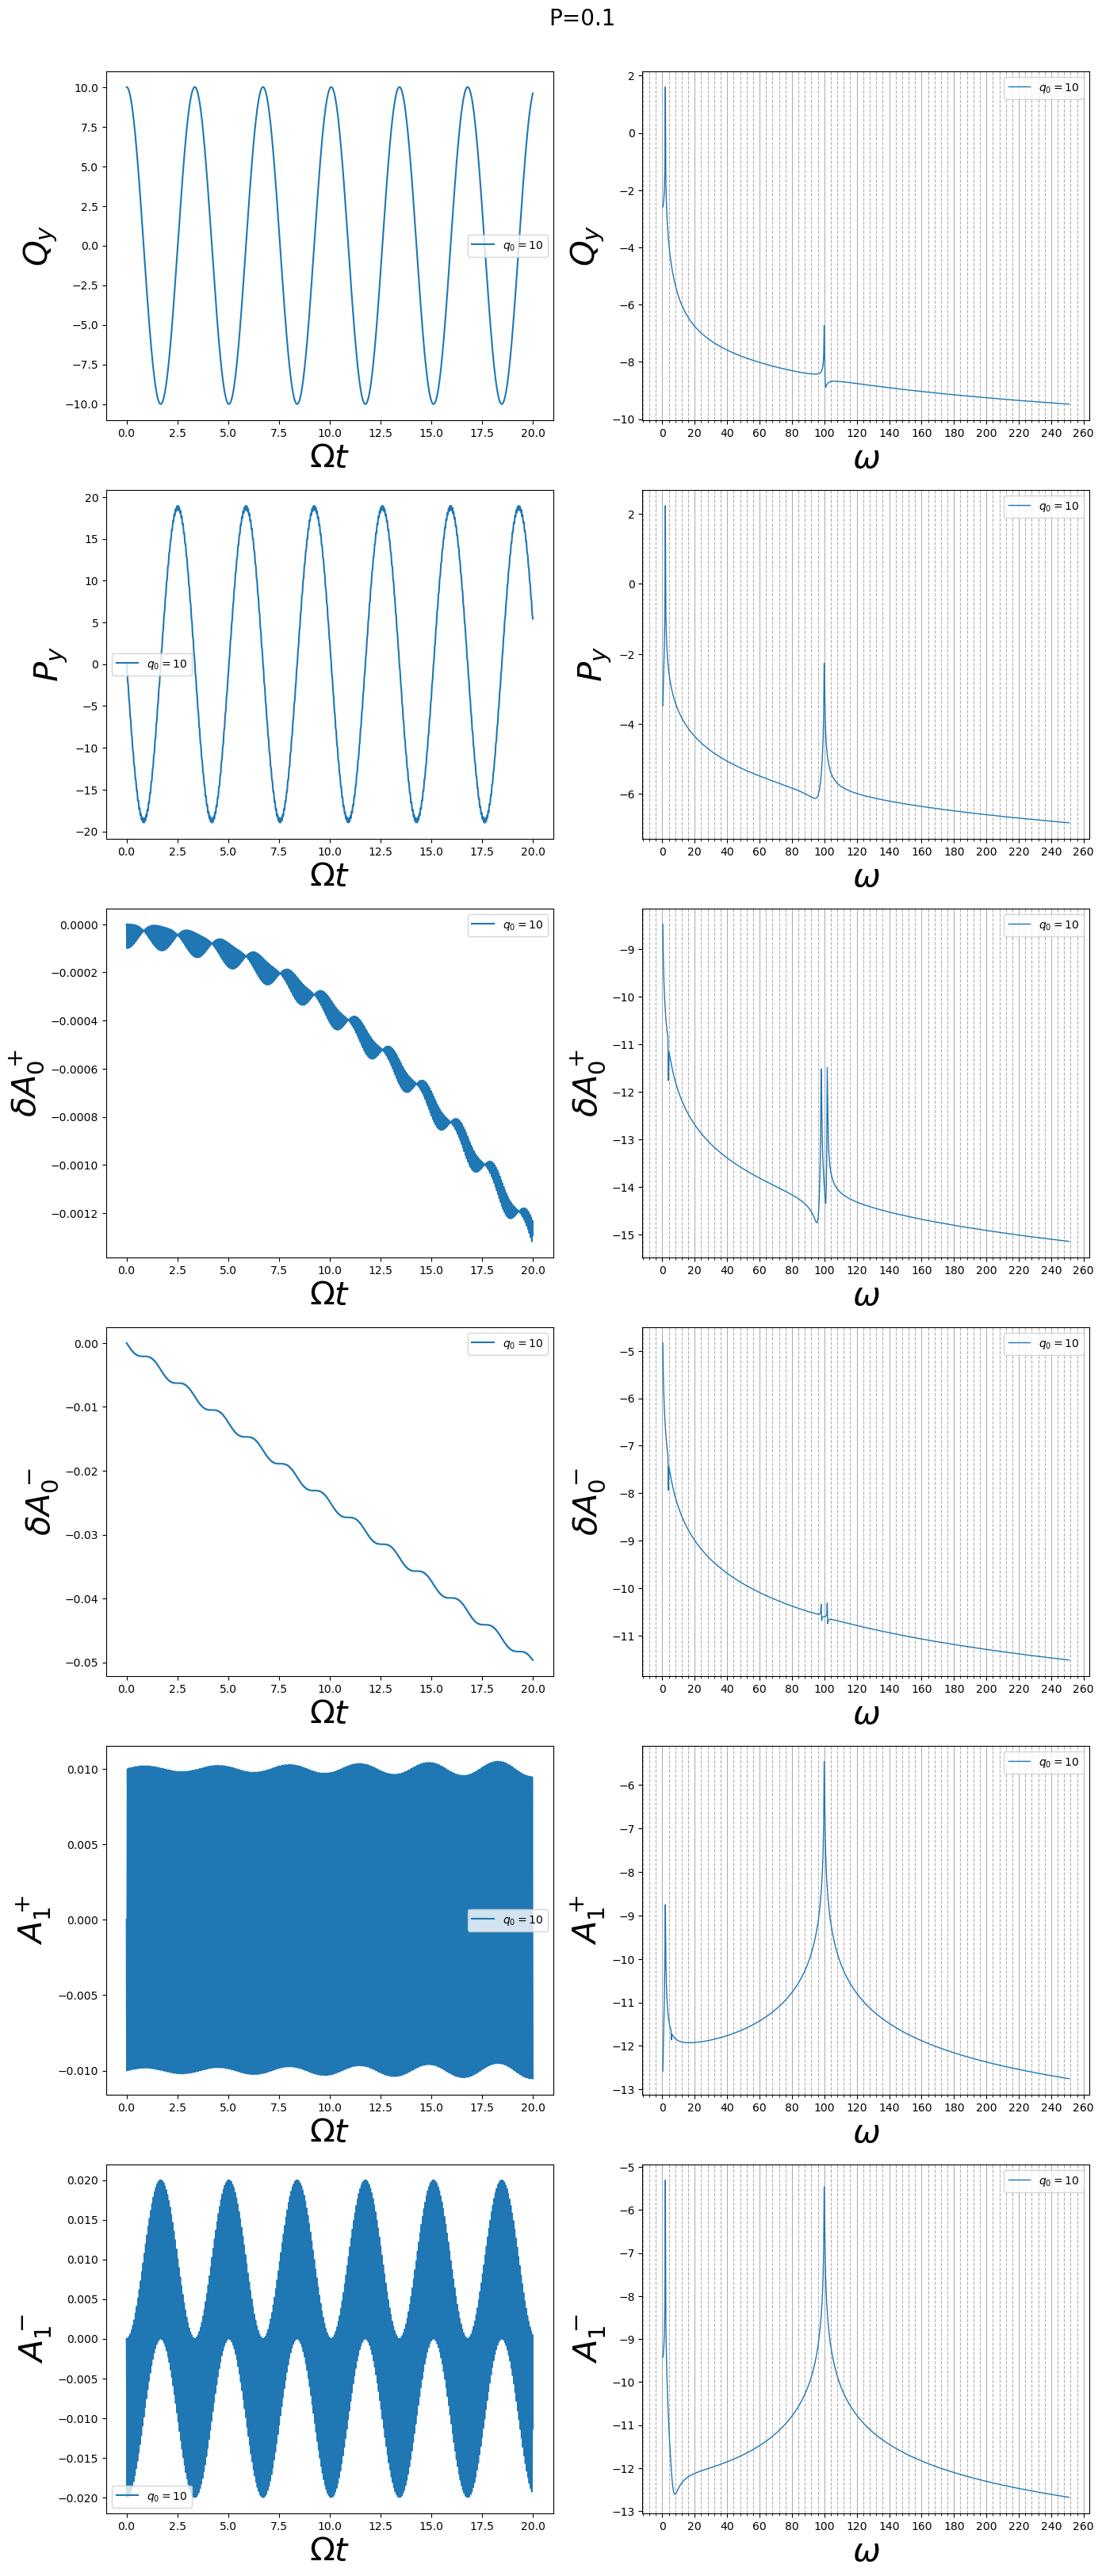

In [6]:
g_z1=0############ 
P=0.1 ############### CRITICAL parameter
g_y=1e-1
N0=(P*del_omega)**3/(8*g_y**2)
print("N0=",np.round(N0))
# title='$g_y={0}\Omega  \: ; \: N_0={1} \: ; \: P_c={2}$'.format(g_y,N0,P)

label_list=["$Q_z$","$P_z$","$Q_y$","$P_y$","$\delta A_0^+$","$\delta A_0^-$","$A_1^+$","$A_1^-$","$H$","$N$"]
tf=2e1
N_step=10000
qy_0_list=[10]
sf,ef=1,800
om=2*np.pi*np.arange(N_step//2+1)[sf:ef]/tf
fig, axs = plt.subplots(6, 2,figsize=(16,40))

for qy_0 in (qy_0_list):
    z_0=np.array([0,0,qy_0,0,0,0,0,0])

    param_list=[g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
    zz,t=real_evolve(z_0,tf,param_list,N_step)
    label="$q_0={0}$".format(qy_0)
    for i in range(6):
#         axs[i,0].plot(t,zz[i]/qy_0**2,label=label)
        axs[i,0].plot(t,zz[i+2],label=label)
        zff=np.log(np.abs(np.fft.rfft(zz[i+2]))/N_step)
#         zff=(np.abs(np.fft.rfft(zz[i]))/N_step)
        axs[i,1].plot(om,zff[sf:ef],label=label,linewidth=1)
title="P={0}".format(P)
plt.suptitle(title,fontsize=20,y=0.9)

for i in range(6):
    axs[i,0].set_ylabel(label_list[i+2],fontsize=30)
    axs[i,0].set_xlabel('$\Omega t$',fontsize=30)
    axs[i,0].legend()

    axs[i,1].set_ylabel(label_list[i+2],fontsize=30)
    axs[i,1].set_xlabel('$\omega$',fontsize=30)
    axs[i,1].legend()
    axs[i,1].xaxis.set_major_locator(plticker.MultipleLocator(20*2))
    axs[i,1].xaxis.set_minor_locator(plticker.MultipleLocator(4*2))
    axs[i,1].grid(axis = 'x',which="major")
    axs[i,1].grid(axis = 'x',which="minor", linestyle='--')
    #     axs[i//2,i%2].legend(fontsize=12)

plt.show() 

N0= 12500.0


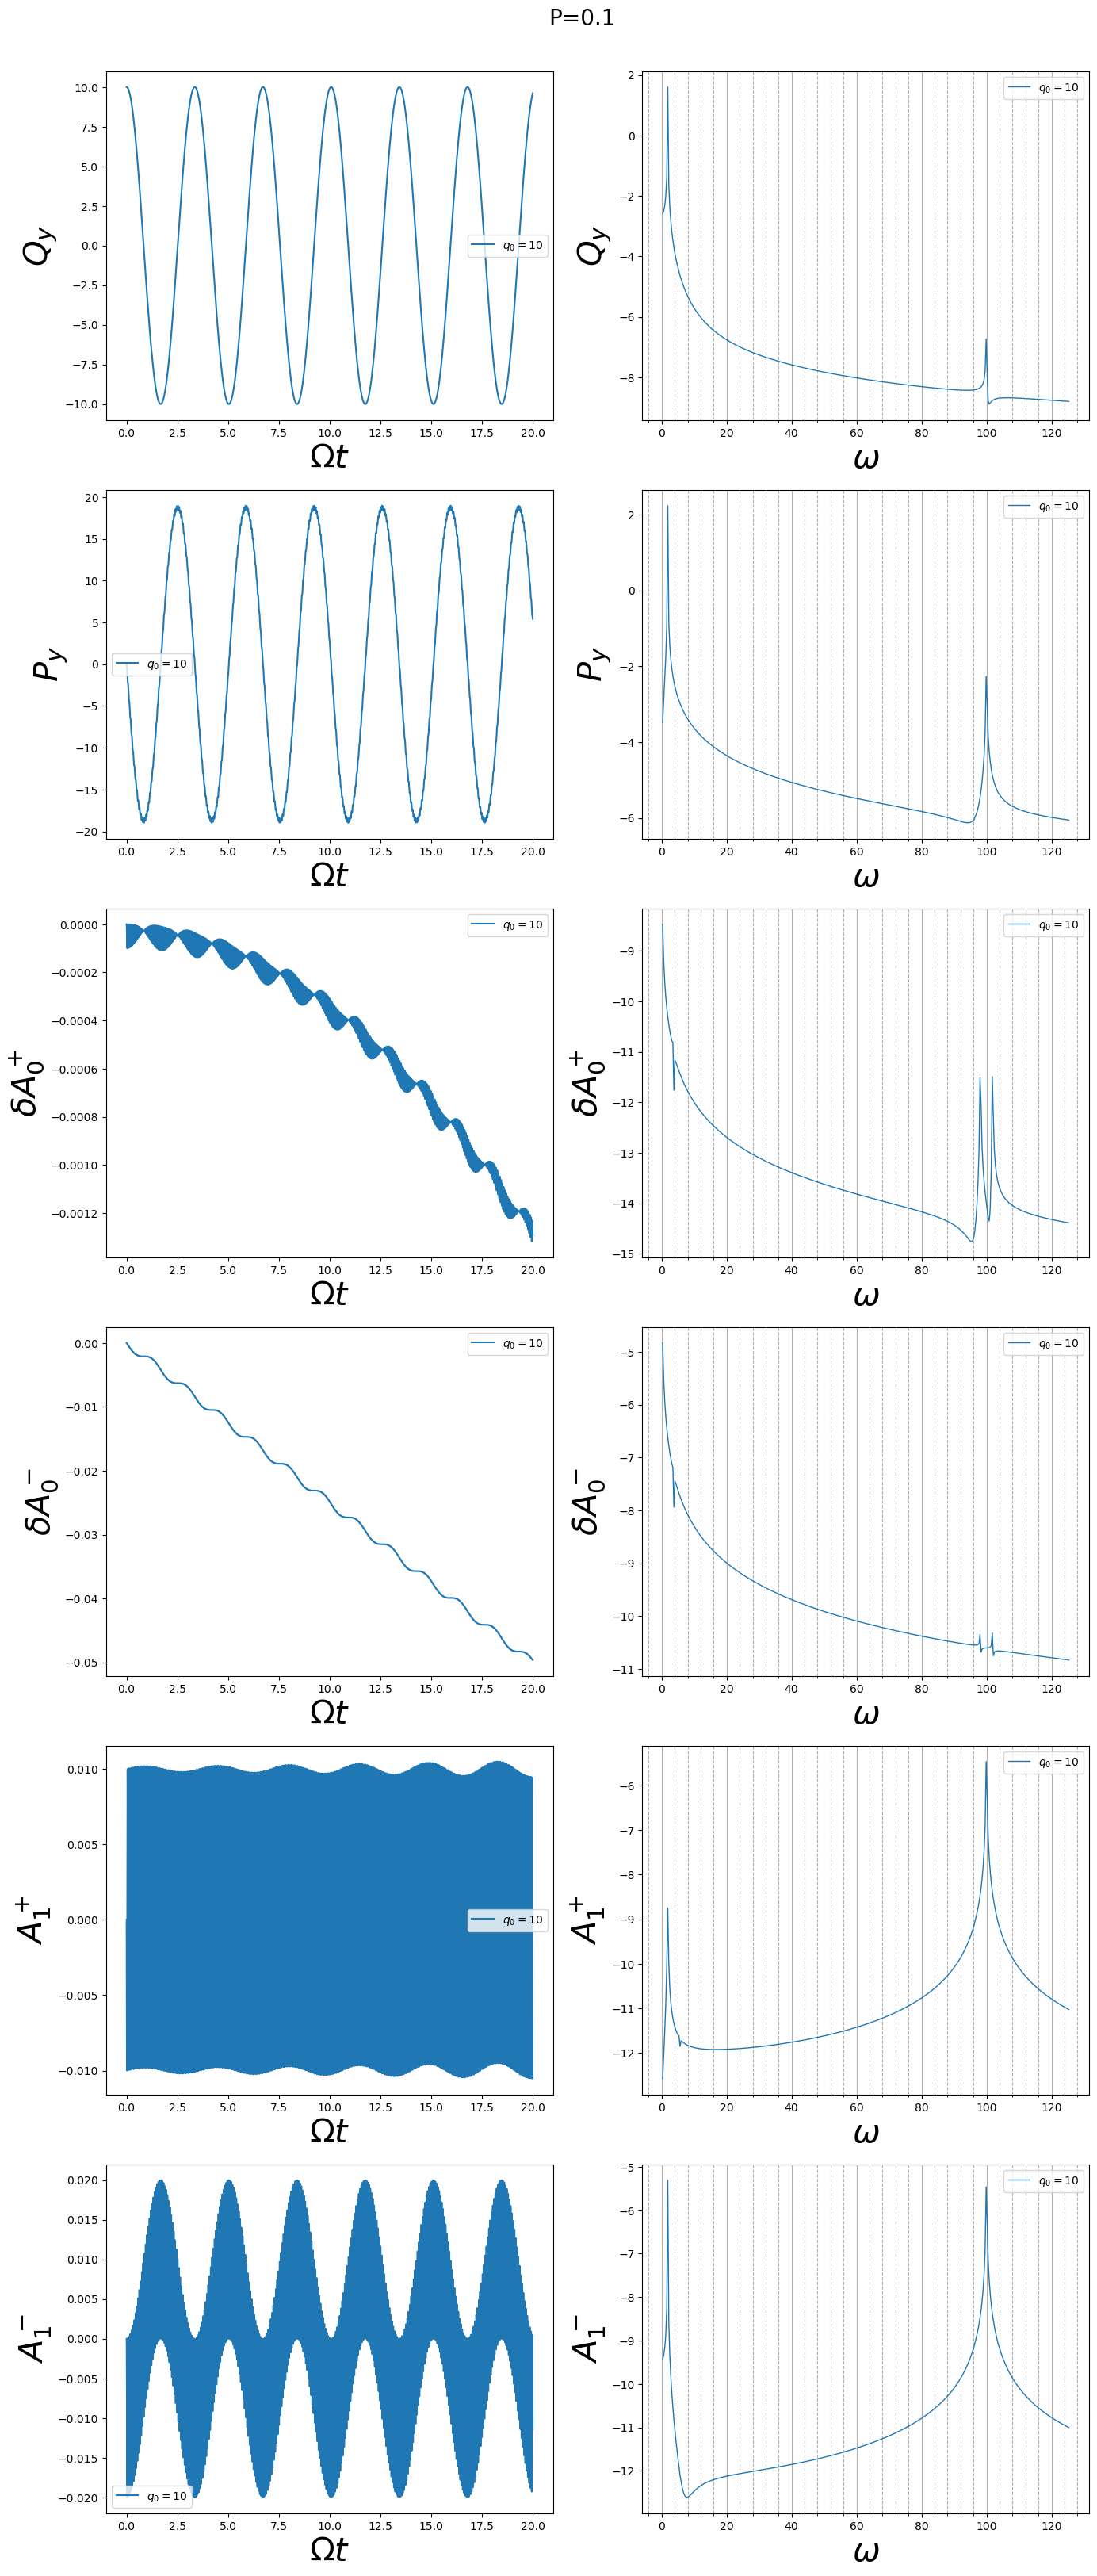

In [7]:
g_z1=0############ 
P=0.1 ############### CRITICAL parameter
g_y=1e-1
N0=(P*del_omega)**3/(8*g_y**2)
print("N0=",np.round(N0))
# title='$g_y={0}\Omega  \: ; \: N_0={1} \: ; \: P_c={2}$'.format(g_y,N0,P)

label_list=["$Q_z$","$P_z$","$Q_y$","$P_y$","$\delta A_0^+$","$\delta A_0^-$","$A_1^+$","$A_1^-$","$H$","$N$"]
tf=2e1
N_step=10000
qy_0_list=[10]
sf,ef=1,400
om=2*np.pi*np.arange(N_step//2+1)[sf:ef]/tf
fig, axs = plt.subplots(6, 2,figsize=(16,40))

for qy_0 in (qy_0_list):
    z_0=np.array([0,0,qy_0,0,0,0,0,0])

    param_list=[g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
    zz,t=real_evolve(z_0,tf,param_list,N_step)
    label="$q_0={0}$".format(qy_0)
    for i in range(6):
#         axs[i,0].plot(t,zz[i]/qy_0**2,label=label)
        axs[i,0].plot(t,zz[i+2],label=label)
        zff=np.log(np.abs(np.fft.rfft(zz[i+2]))/N_step)
#         zff=(np.abs(np.fft.rfft(zz[i]))/N_step)
        axs[i,1].plot(om,zff[sf:ef],label=label,linewidth=1)
title="P={0}".format(P)
plt.suptitle(title,fontsize=20,y=0.9)

for i in range(6):
    axs[i,0].set_ylabel(label_list[i+2],fontsize=30)
    axs[i,0].set_xlabel('$\Omega t$',fontsize=30)
    axs[i,0].legend()

    axs[i,1].set_ylabel(label_list[i+2],fontsize=30)
    axs[i,1].set_xlabel('$\omega$',fontsize=30)
    axs[i,1].legend()
    axs[i,1].xaxis.set_major_locator(plticker.MultipleLocator(20))
    axs[i,1].xaxis.set_minor_locator(plticker.MultipleLocator(4))
    axs[i,1].grid(axis = 'x',which="major")
    axs[i,1].grid(axis = 'x',which="minor", linestyle='--')
    #     axs[i//2,i%2].legend(fontsize=12)

plt.show() 

N0= 12500.0


C:\Users\jhash\AppData\Local\Temp\ipykernel_11276\1584290803.py:35: RuntimeWarning: divide by zero encountered in log
  zff=np.log(np.abs(np.fft.rfft(sol[i][j]))/N_step)


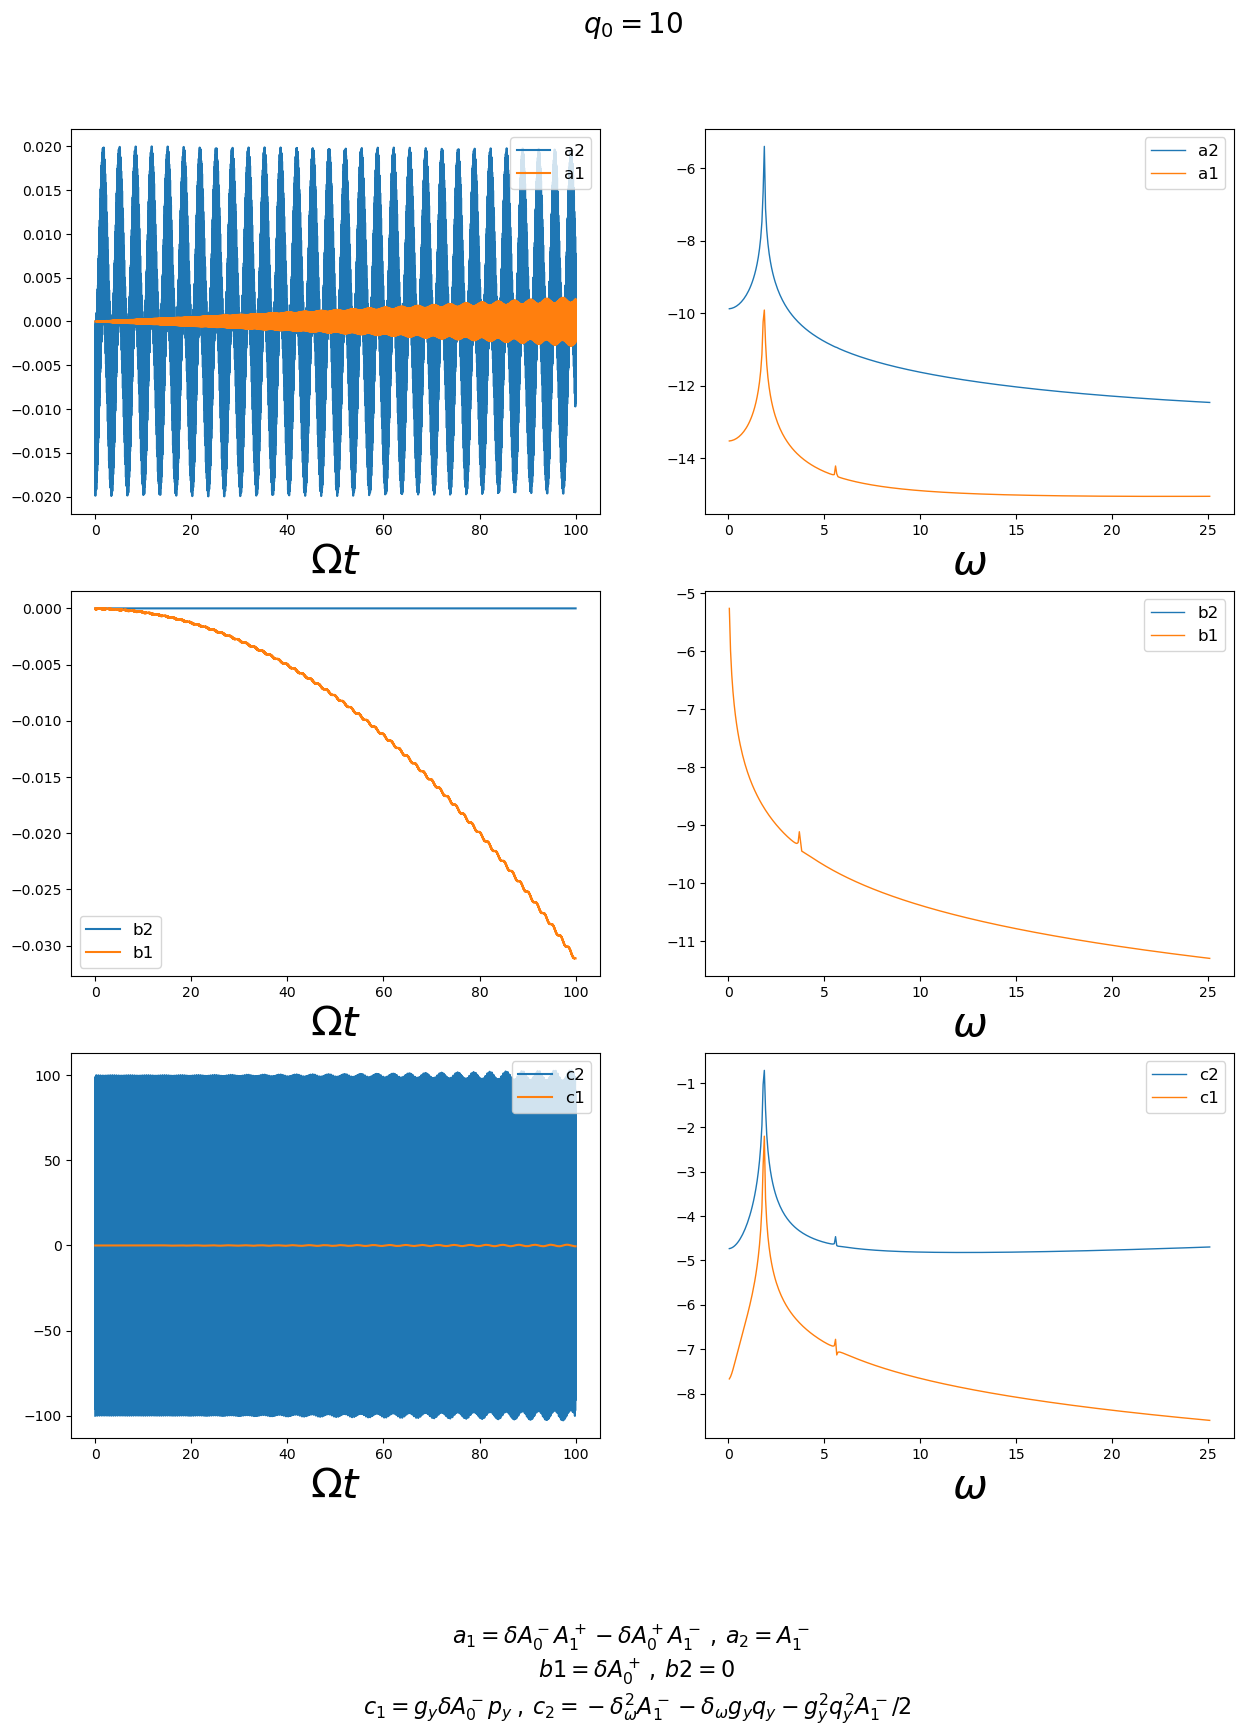

In [27]:
g_z1=0
P=0.1 ############### CRITICAL parameter
g_y=1e-1
N0=np.round((P*del_omega)**3/(8*g_y**2))
print("N0=",N0)
title='$g_y={0}\Omega  \: ; \: N_0={1} \: ; \: P_c={2}$'.format(g_y,N0,P)

label_list=["$Q_z$","$P_z$","$Q_y$","$P_y$","$\delta A_0^+$","$\delta A_0^-$","$A_1^+$","$A_1^-$","$H$","$N$"]
#              0       1       2        3        4                 5               6         7      8      9
tf=1e2
N_step=10000
fig, axs = plt.subplots(3, 2,figsize=(15,17))  ## (width,height)
# fig.suptitle('Dynamics with varying '+"$P_c$"+" , with only initial mechanical pumping", fontsize=20)
qy_0=10
z_0=np.array([0,0,qy_0,0,0,0,0,0])  ### 0 mode excitation
sf,ef=1,400
om=2*np.pi*np.arange(N_step//2+1)[sf:ef]/tf
param_list=[g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
zz,t=real_evolve(z_0,tf,param_list,N_step)
sol=[]
# sol.append([zz[7]-zz[2]/(2*g_y*N0),(zz[6]*zz[5]-zz[7]*zz[4])])
sol.append([zz[7],(zz[6]*zz[5]-zz[7]*zz[4])])

# sol.append([-del_omega**2*zz[7]-del_omega*g_y*zz[2]-(g_y*zz[2])**2*zz[7]/2,del_omega*g_y*zz[4]*zz[2]])
sol.append([zz[4]*0,zz[4]])

sol.append([-del_omega**2*zz[7]-del_omega*g_y*zz[2]-(g_y*zz[2])**2*zz[7]/2,g_y*zz[5]*zz[3]])
# sol.append([-del_omega**2*zz[7]-del_omega*g_y*zz[2]-(g_y*zz[2])**2*zz[7]/2,del_omega*g_y*zz[4]*zz[2]])

row_list=["a","b","c","d"]
col_list=["2","1"]
for i in range(3):
    for j in range(2):
        axs[i,0].plot(t,sol[i][j],label=row_list[i]+col_list[j])
        zff=np.log(np.abs(np.fft.rfft(sol[i][j]))/N_step)
#         zff=(np.abs(np.fft.rfft(zz[i]))/N_step)
        axs[i,1].plot(om,zff[sf:ef],label=row_list[i]+col_list[j],linewidth=1)
#     axs[i//2,i%2].set_ylabel(row_list[i]+col_list[j],fontsize=30)
    axs[i,0].set_xlabel('$\Omega  t$',fontsize=30)
    axs[i,1].set_xlabel('$\omega$',fontsize=30)
    axs[i,0].legend(fontsize=12)
    axs[i,1].legend(fontsize=12)
plt.suptitle("$q_0={0}$".format(qy_0),fontsize=20,y=0.95)
# txt="a1=$\delta A_0^- A_1^+ - \delta A_0^+ A_1^-$ a2=$A_1^- \n$ b1=$\delta A_0^+$ b2= $0 \n$ c1=$g_y \deltaA_0^- p_y$ c2= $-delta_\omega^2 A_1^- -\delta_\omega g_y q_y -g_y^2 q_y^2 A_1^-/2$"
# txt='$a1=\delta A_0^- A_1^+ - \delta A_0^+ A_1^- a2=A_1^-  b1=\delta A_0^+ b2= 0  c1=g_y \deltaA_0^- p_y c2= -delta_\omega^2 A_1^- -\delta_\omega g_y q_y -g_y^2 q_y^2 A_1^-/2$'
# txt='$g_y={0}\Omega  \: ; \: N_0={1} \: ; \: P_c={2}$'.format(g_y,N0,P)
txt='$a_1=\delta A_0^- A_1^+ - \delta A_0^+ A_1^- \: , \:a_2=A_1^- $ \n $b1=\delta A_0^+ \: , \:b2= 0$ \n $c_1=g_y \delta A_0^- p_y \: , \:c_2= -\delta_\omega^2 A_1^- -\delta_\omega g_y q_y -g_y^2 q_y^2 A_1^-/2$'
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=16)
plt.show() 

N0= 12500.0


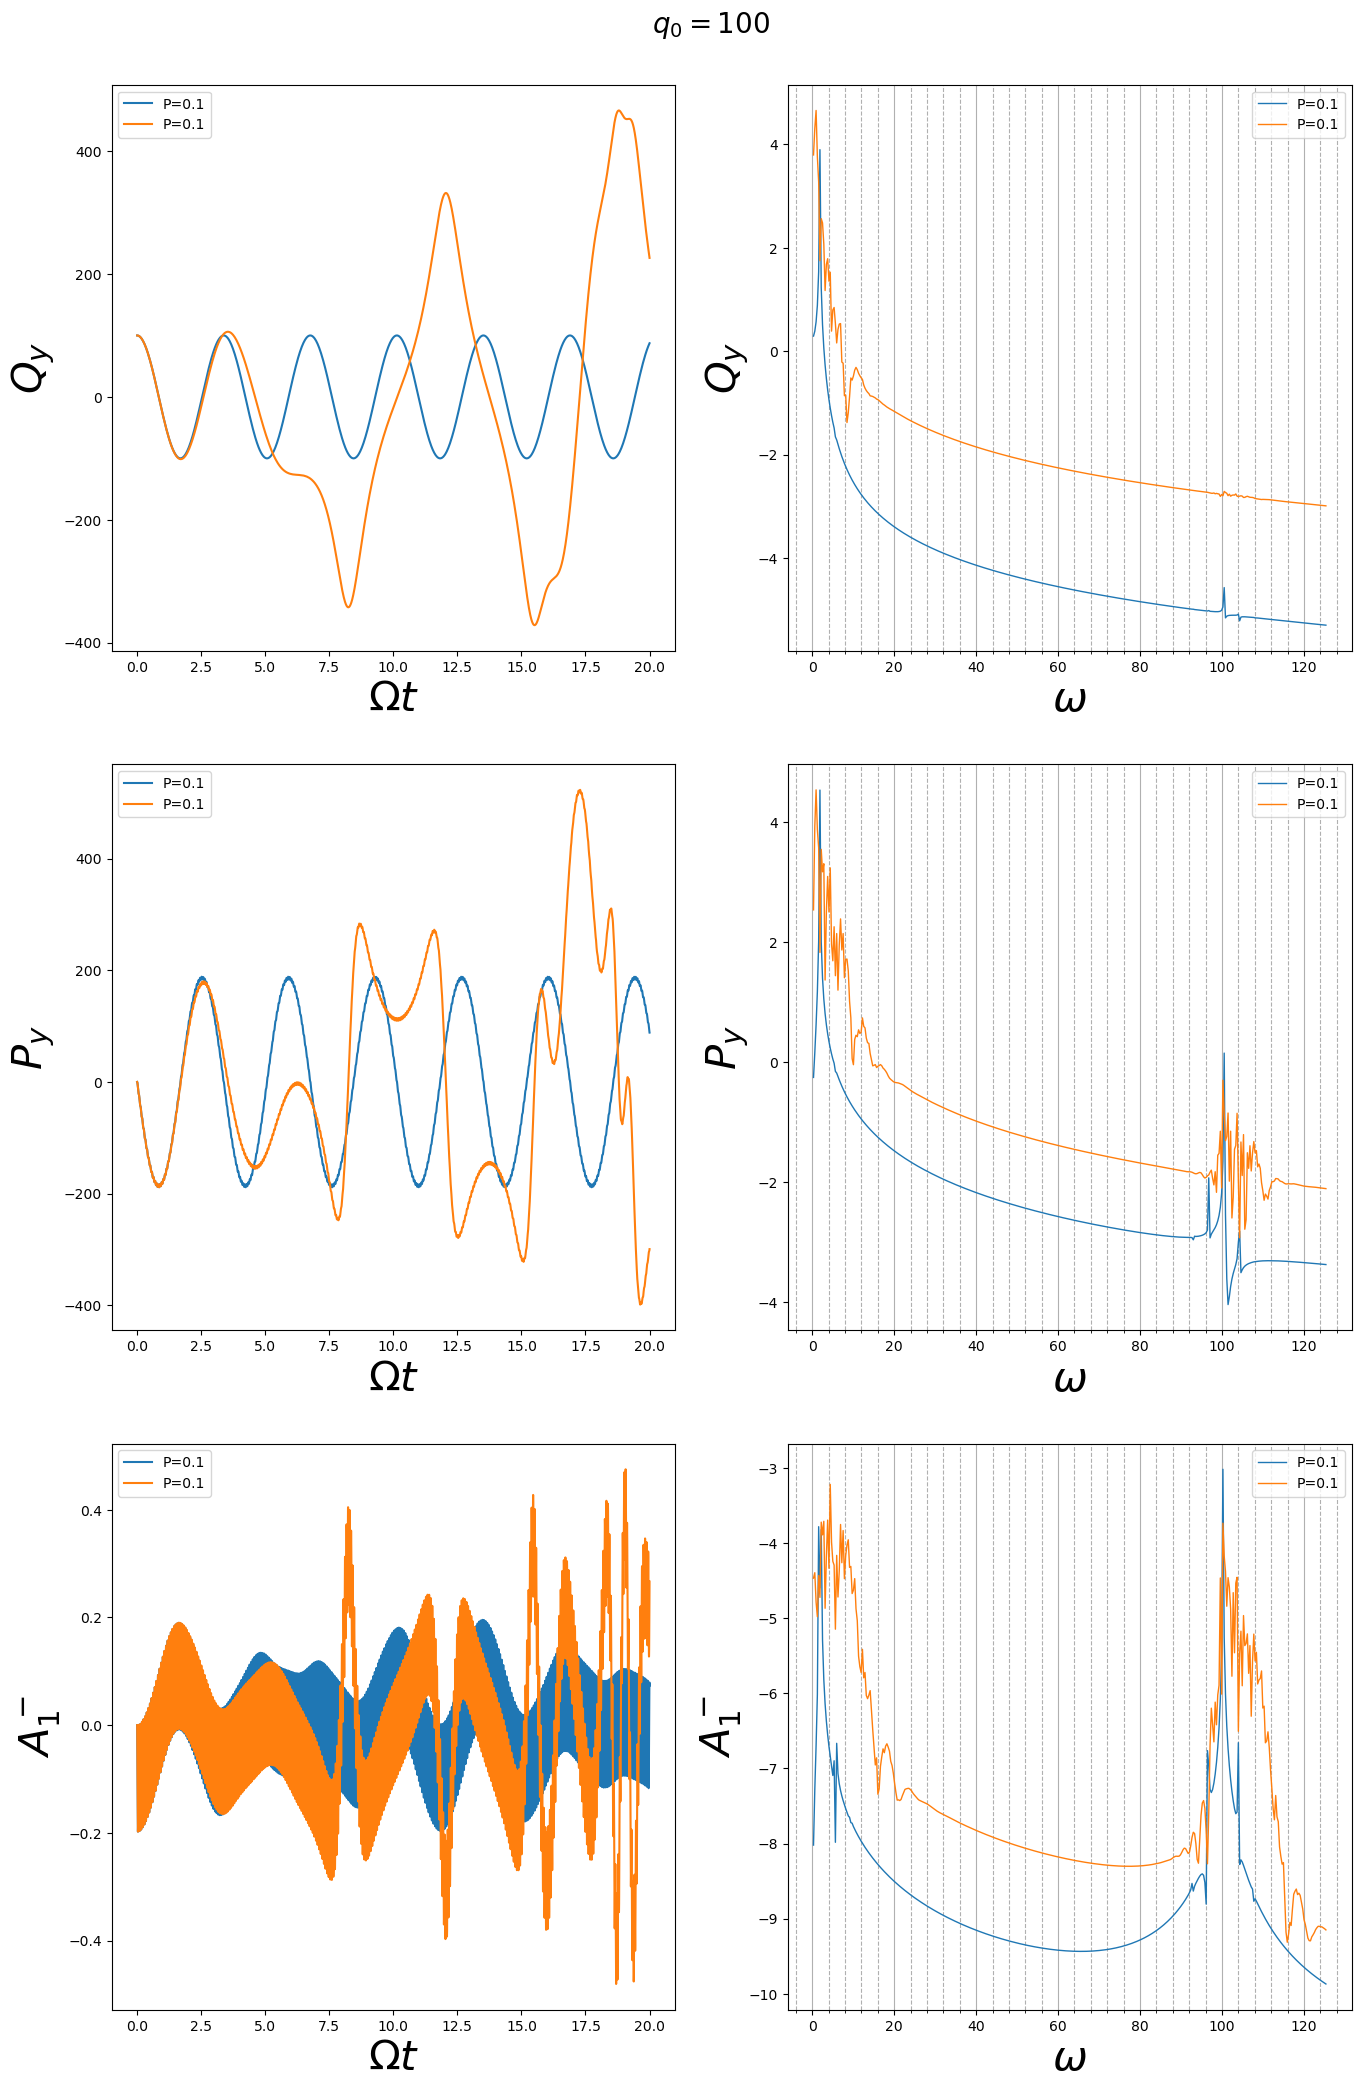

In [14]:
g_z1=0############ 
P_list=np.array([0.1]) ############### CRITICAL parameter
g_y=1e-1
print("N0=",np.round(N0))

label_list=["$Q_y$","$P_y$","$A_1^-$"]
# label_list=["$Q_z$","$P_z$","$Q_y$","$P_y$","$\delta A_0^+$","$\delta A_0^-$","$A_1^+$","$A_1^-$","$H$","$N$"]

tf=2e1
N_step=10000
qy_0=100
z_0=np.array([0,0,qy_0,0,0,0,0,0, N0*del_omega,0,0, qy_0**2/4,0],dtype=complex)  ### 0 mode excitation
sf,ef=1,400
om=2*np.pi*np.arange(N_step//2+1)[sf:ef]/tf

i=7
fig, axs = plt.subplots(3, 2,figsize=(16,25))
# i_list=[2,3,7]
for P in (P_list):
    N0=(P*del_omega)**3/(8*g_y**2)
    param_list=[g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
    
    z_0=np.array([0,0,qy_0,0,0,0,0,0, N0*del_omega,0,0, qy_0**2/4,0],dtype=complex)  ### 0 mode excitation
    zz1,t=real_evolve(z_0,tf,param_list,N_step,f=real_ODE)
    zz2,t=real_evolve(z_0,tf,param_list,N_step,f=real_ODE2)

    for i in range(3):
        axs[i,0].plot(t,zz1[i],label="P={0}".format(P))
        axs[i,0].plot(t,zz2[i],label="P={0}".format(P))
        zff1=np.log(np.abs(np.fft.rfft(zz1[i]))/N_step)
        zff2=np.log(np.abs(np.fft.rfft(zz2[i]))/N_step)
#         zff=(np.abs(np.fft.rfft(zz[i]))/N_step)
        axs[i,1].plot(om,zff1[sf:ef],label="P={0}".format(P),linewidth=1)
        axs[i,1].plot(om,zff2[sf:ef],label="P={0}".format(P),linewidth=1)

for i in range(3):
    axs[i,0].set_ylabel(label_list[i],fontsize=30)
    axs[i,0].set_xlabel('$\Omega t$',fontsize=30)
    axs[i,0].legend()

    axs[i,1].set_ylabel(label_list[i],fontsize=30)
    axs[i,1].set_xlabel('$\omega$',fontsize=30)
    axs[i,1].legend()
    axs[i,1].xaxis.set_major_locator(plticker.MultipleLocator(20))
    axs[i,1].xaxis.set_minor_locator(plticker.MultipleLocator(4))
    axs[i,1].grid(axis = 'x',which="major")
    axs[i,1].grid(axis = 'x',which="minor", linestyle='--')
    #     axs[i//2,i%2].legend(fontsize=12)
plt.suptitle("$q_0={0}$".format(qy_0),fontsize=20,y=0.91)
plt.show() 

N0= 12500.0


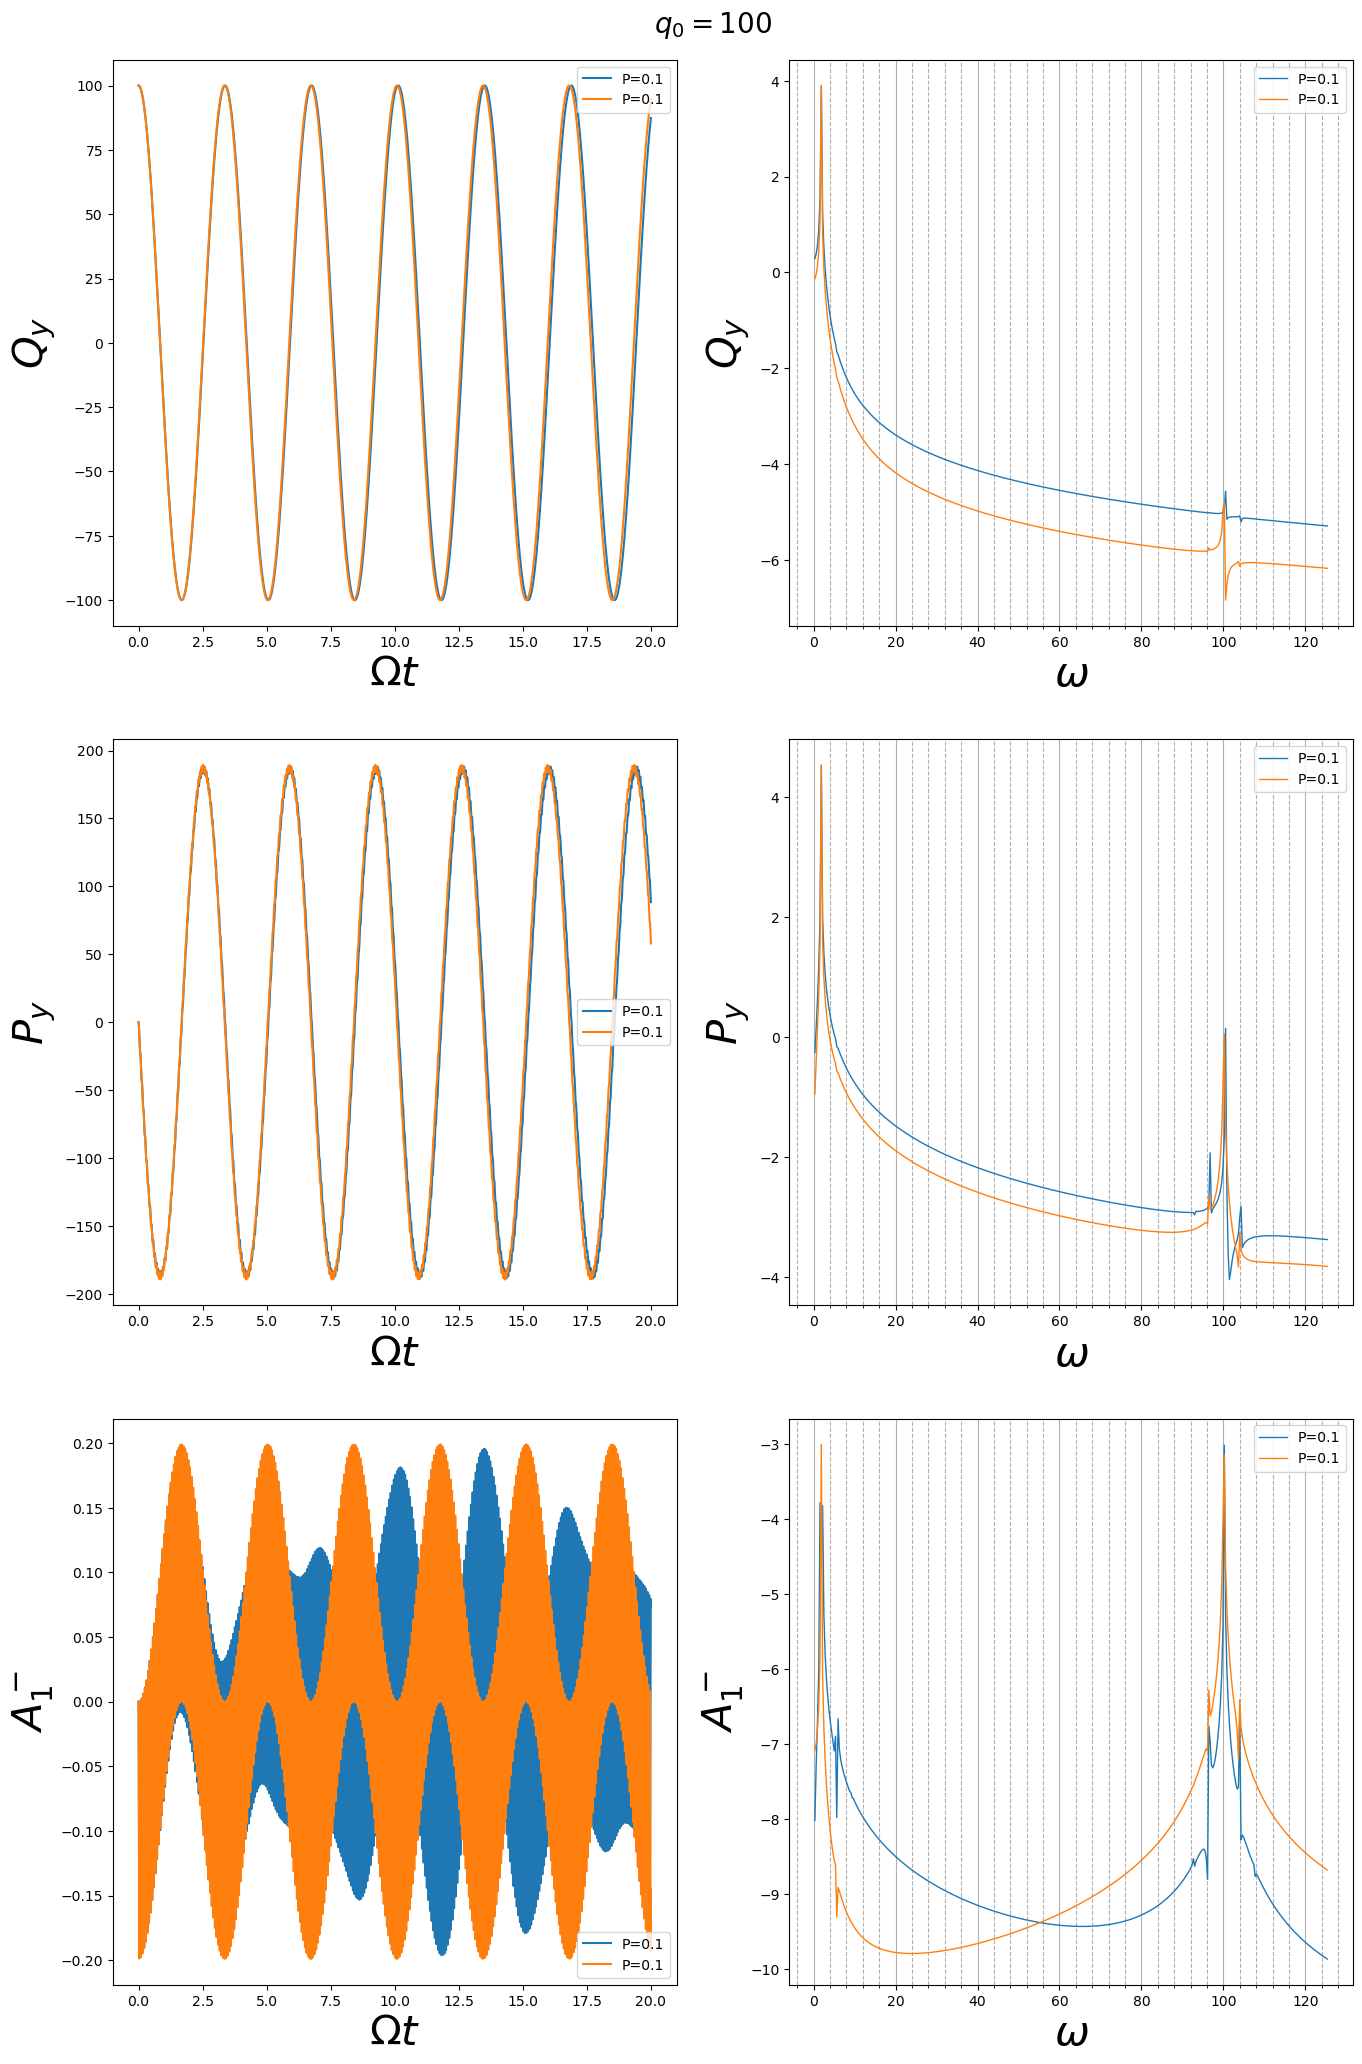

In [13]:
g_z1=0############ 
P_list=np.array([0.1]) ############### CRITICAL parameter
g_y=1e-1
print("N0=",np.round(N0))

label_list=["$Q_y$","$P_y$","$A_1^-$"]
# label_list=["$Q_z$","$P_z$","$Q_y$","$P_y$","$\delta A_0^+$","$\delta A_0^-$","$A_1^+$","$A_1^-$","$H$","$N$"]

tf=2e1
N_step=10000
qy_0=100
z_0=np.array([0,0,qy_0,0,0,0,0,0, N0*del_omega,0,0, qy_0**2/4,0],dtype=complex)  ### 0 mode excitation
sf,ef=1,400
om=2*np.pi*np.arange(N_step//2+1)[sf:ef]/tf

i=7
fig, axs = plt.subplots(3, 2,figsize=(16,25))
# i_list=[2,3,7]
for P in (P_list):
    N0=(P*del_omega)**3/(8*g_y**2)
    param_list=[g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
    
    z_0=np.array([0,0,qy_0,0,0,0,0,0, N0*del_omega,0,0, qy_0**2/4,0],dtype=complex)  ### 0 mode excitation
    zz_real,t=real_evolve(z_0,tf,param_list,N_step)
    z_0=np.array([qy_0,0,0,0],dtype=complex)  ### 0 mode excitation
    zz_red,t=reduced_evolve(z_0,tf,param_list,N_step)

    for i in range(3):
        axs[i,0].plot(t,zz_real[i],label="P={0}".format(P))
        axs[i,0].plot(t,zz_red[i],label="P={0}".format(P))
        zff_real=np.log(np.abs(np.fft.rfft(zz_real[i]))/N_step)
        zff_red=np.log(np.abs(np.fft.rfft(zz_red[i]))/N_step)
#         zff=(np.abs(np.fft.rfft(zz[i]))/N_step)
        axs[i,1].plot(om,zff_real[sf:ef],label="P={0}".format(P),linewidth=1)
        axs[i,1].plot(om,zff_red[sf:ef],label="P={0}".format(P),linewidth=1)

for i in range(3):
    axs[i,0].set_ylabel(label_list[i],fontsize=30)
    axs[i,0].set_xlabel('$\Omega t$',fontsize=30)
    axs[i,0].legend()

    axs[i,1].set_ylabel(label_list[i],fontsize=30)
    axs[i,1].set_xlabel('$\omega$',fontsize=30)
    axs[i,1].legend()
    axs[i,1].xaxis.set_major_locator(plticker.MultipleLocator(20))
    axs[i,1].xaxis.set_minor_locator(plticker.MultipleLocator(4))
    axs[i,1].grid(axis = 'x',which="major")
    axs[i,1].grid(axis = 'x',which="minor", linestyle='--')
    #     axs[i//2,i%2].legend(fontsize=12)
plt.suptitle("$q_0={0}$".format(qy_0),fontsize=20,y=0.91)
plt.show() 

N0= 12500.0


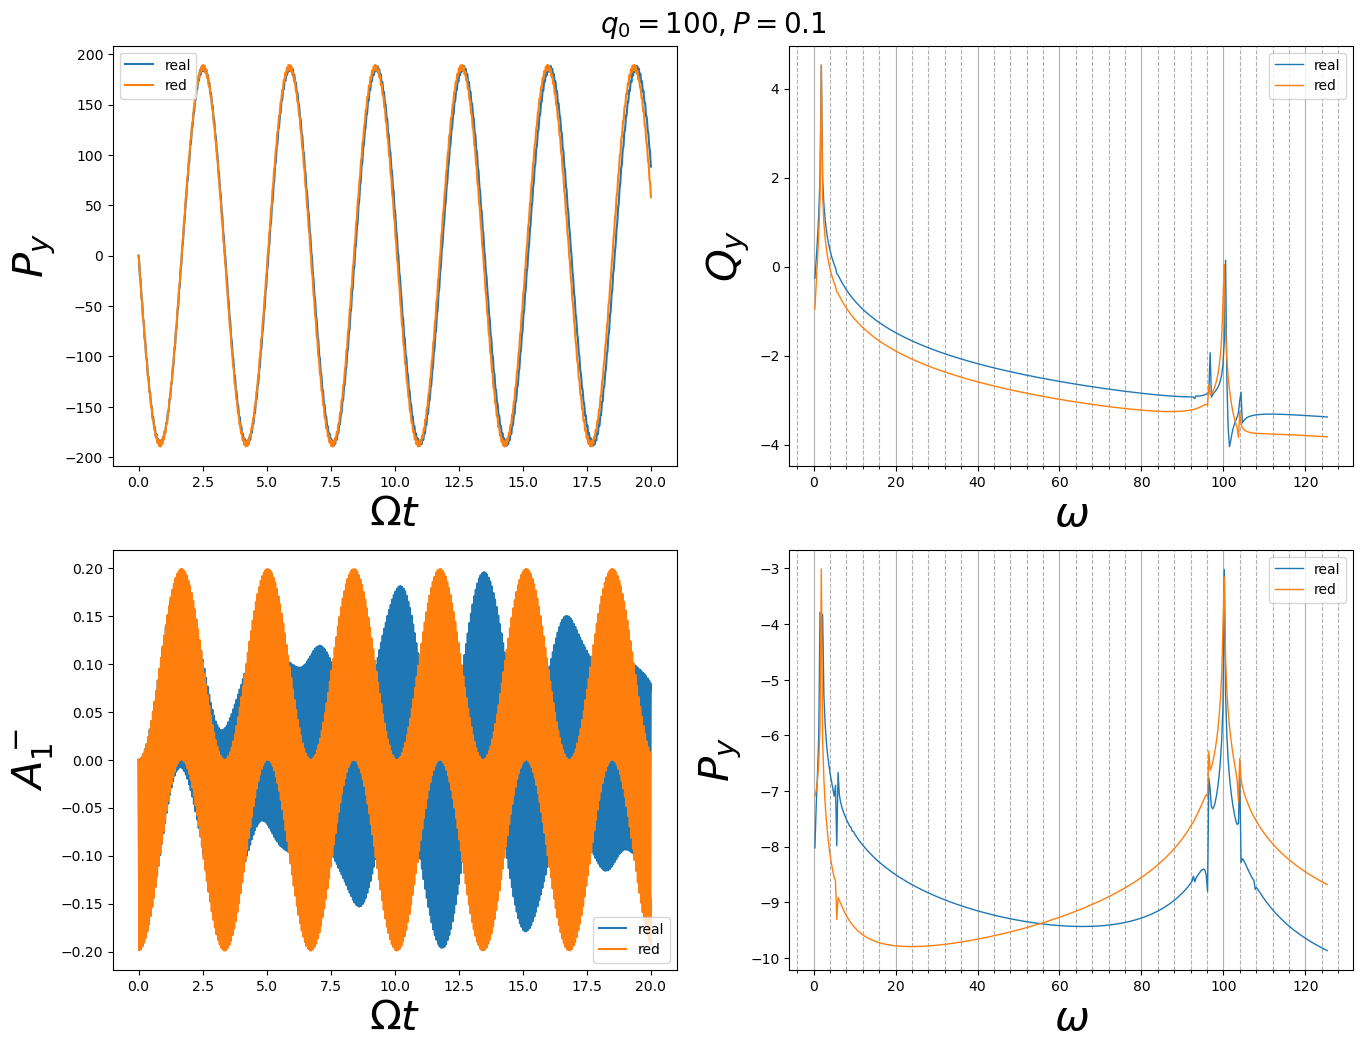

In [32]:
g_z1=0############ 
P_list=np.array([0.1]) ############### CRITICAL parameter
g_y=1e-1
print("N0=",np.round(N0))

label_list=["$Q_y$","$P_y$","$A_1^-$"]
# label_list=["$Q_z$","$P_z$","$Q_y$","$P_y$","$\delta A_0^+$","$\delta A_0^-$","$A_1^+$","$A_1^-$","$H$","$N$"]


tf=2e1
N_step=10000
qy_0=100
sf,ef=1,400
om=2*np.pi*np.arange(N_step//2+1)[sf:ef]/tf

i=7
fig, axs = plt.subplots(2, 2,figsize=(16,12))
# i_list=[2,3,7]
for P in (P_list):
    N0=(P*del_omega)**3/(8*g_y**2)
    param_list=[g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
    
    z_0=np.array([0,0,qy_0,0,0,0,0,0],dtype=complex)  ### 0 mode excitation
    zz_real,t=real_evolve(z_0,tf,param_list,N_step)
    z_0=np.array([qy_0,0,0,0],dtype=complex)  ### 0 mode excitation
    zz_red,t=reduced_evolve(z_0,tf,param_list,N_step)

    for i in range(2):
        axs[i,0].plot(t,zz_real[i+1],label="real")
        axs[i,0].plot(t,zz_red[i+1],label="red")
        zff_real=np.log(np.abs(np.fft.rfft(zz_real[i+1]))/N_step)
        zff_red=np.log(np.abs(np.fft.rfft(zz_red[i+1]))/N_step)
#         zff=(np.abs(np.fft.rfft(zz[i]))/N_step)
        axs[i,1].plot(om,zff_real[sf:ef],label="real",linewidth=1)
        axs[i,1].plot(om,zff_red[sf:ef],label="red",linewidth=1)

for i in range(2):
    axs[i,0].set_ylabel(label_list[i+1],fontsize=30)
    axs[i,0].set_xlabel('$\Omega t$',fontsize=30)
    axs[i,0].legend()

    axs[i,1].set_ylabel(label_list[i],fontsize=30)
    axs[i,1].set_xlabel('$\omega$',fontsize=30)
    axs[i,1].legend()
    axs[i,1].xaxis.set_major_locator(plticker.MultipleLocator(20))
    axs[i,1].xaxis.set_minor_locator(plticker.MultipleLocator(4))
    axs[i,1].grid(axis = 'x',which="major")
    axs[i,1].grid(axis = 'x',which="minor", linestyle='--')
    #     axs[i//2,i%2].legend(fontsize=12)
plt.suptitle("$q_0={0},P={1}$".format(qy_0,P),fontsize=20,y=0.91)
plt.show() 

N0= 12500.0


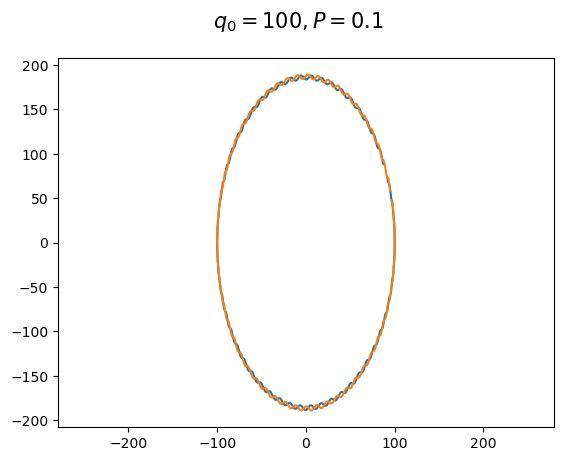

In [41]:
g_z1=0############ 
P_list=np.array([0.1]) ############### CRITICAL parameter
g_y=1e-1
print("N0=",np.round(N0))

label_list=["$Q_y$","$P_y$","$A_1^-$"]
# label_list=["$Q_z$","$P_z$","$Q_y$","$P_y$","$\delta A_0^+$","$\delta A_0^-$","$A_1^+$","$A_1^-$","$H$","$N$"]


tf=2e1
N_step=10000
qy_0=100
sf,ef=1,400
om=2*np.pi*np.arange(N_step//2+1)[sf:ef]/tf
s=N_step//6
# fig, axs = plt.subplots(2, 2,figsize=(16,12))
# i_list=[2,3,7]
for P in (P_list):
    N0=(P*del_omega)**3/(8*g_y**2)
    param_list=[g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
    
    z_0=np.array([0,0,qy_0,0,0,0,0,0],dtype=complex)  ### 0 mode excitation
    zz_real,t=real_evolve(z_0,tf,param_list,N_step)
    z_0=np.array([qy_0,0,0,0],dtype=complex)  ### 0 mode excitation
    zz_red,t=reduced_evolve(z_0,tf,param_list,N_step)

    plt.plot(zz_real[0][-s:],zz_real[1][-s:],label="real")
    plt.plot(zz_red[0][-s:],zz_red[1][-s:],label="red")

plt.suptitle("$q_0={0},P={1}$".format(qy_0,P),fontsize=15)
plt.axis("equal")
plt.show() 

In [35]:
N_grid=100
qy_0_list=(np.linspace(1/N_grid,1,N_grid,endpoint=True)*2e2).astype(int)
P_list=np.round(np.linspace(1/N_grid,1,N_grid,endpoint=True),2)
lam=np.zeros((N_grid,N_grid,6),dtype=complex)

for i,P in enumerate(P_list):
    N0=(P*del_omega)**3/(8*g_y**2)
    for j,qy_0 in enumerate(qy_0_list):
        E=np.linalg.eigvals(evol_mat(del_omega,g_y,N0,qy_0))
        for k in range(6):
            lam[i,j,k]=E[k]

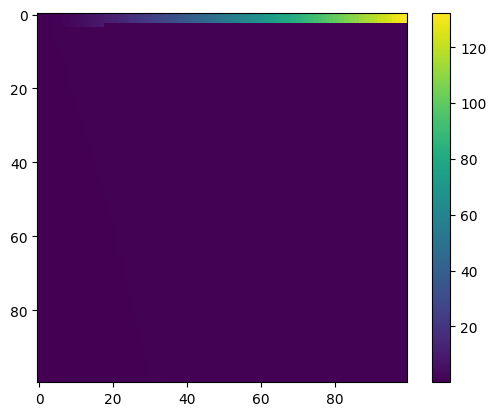

In [38]:
plt.imshow(np.imag(lam[:,:,4]))
plt.colorbar()

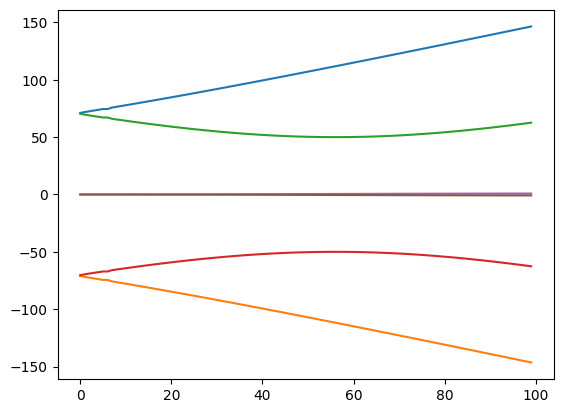

In [49]:
N_grid=100
qy_0_list=(np.linspace(1/N_grid,1,N_grid,endpoint=True)*1e2).astype(int)
P=1
lam=np.zeros((N_grid,6),dtype=complex)

N0=(P*del_omega)**3/(8*g_y**2)
for j,qy_0 in enumerate(qy_0_list):
    E=np.linalg.eigvals(evol_mat(del_omega,g_y,N0,qy_0))
    for k in range(6):
        lam[j,k]=E[k]
        
for i in range(6):
    plt.plot(np.imag(lam[:,i]))
    
plt.show()

In [50]:
lam[0,:]

array([ 1.39019724e-13+7.10852286e+01j,  1.39019724e-13-7.10852286e+01j,
       -1.41796100e-13+7.03521704e+01j, -1.41796100e-13-7.03521704e+01j,
       -8.41702100e-19+1.53729251e-04j, -8.41702100e-19-1.53729251e-04j])

N0= 16637500.0


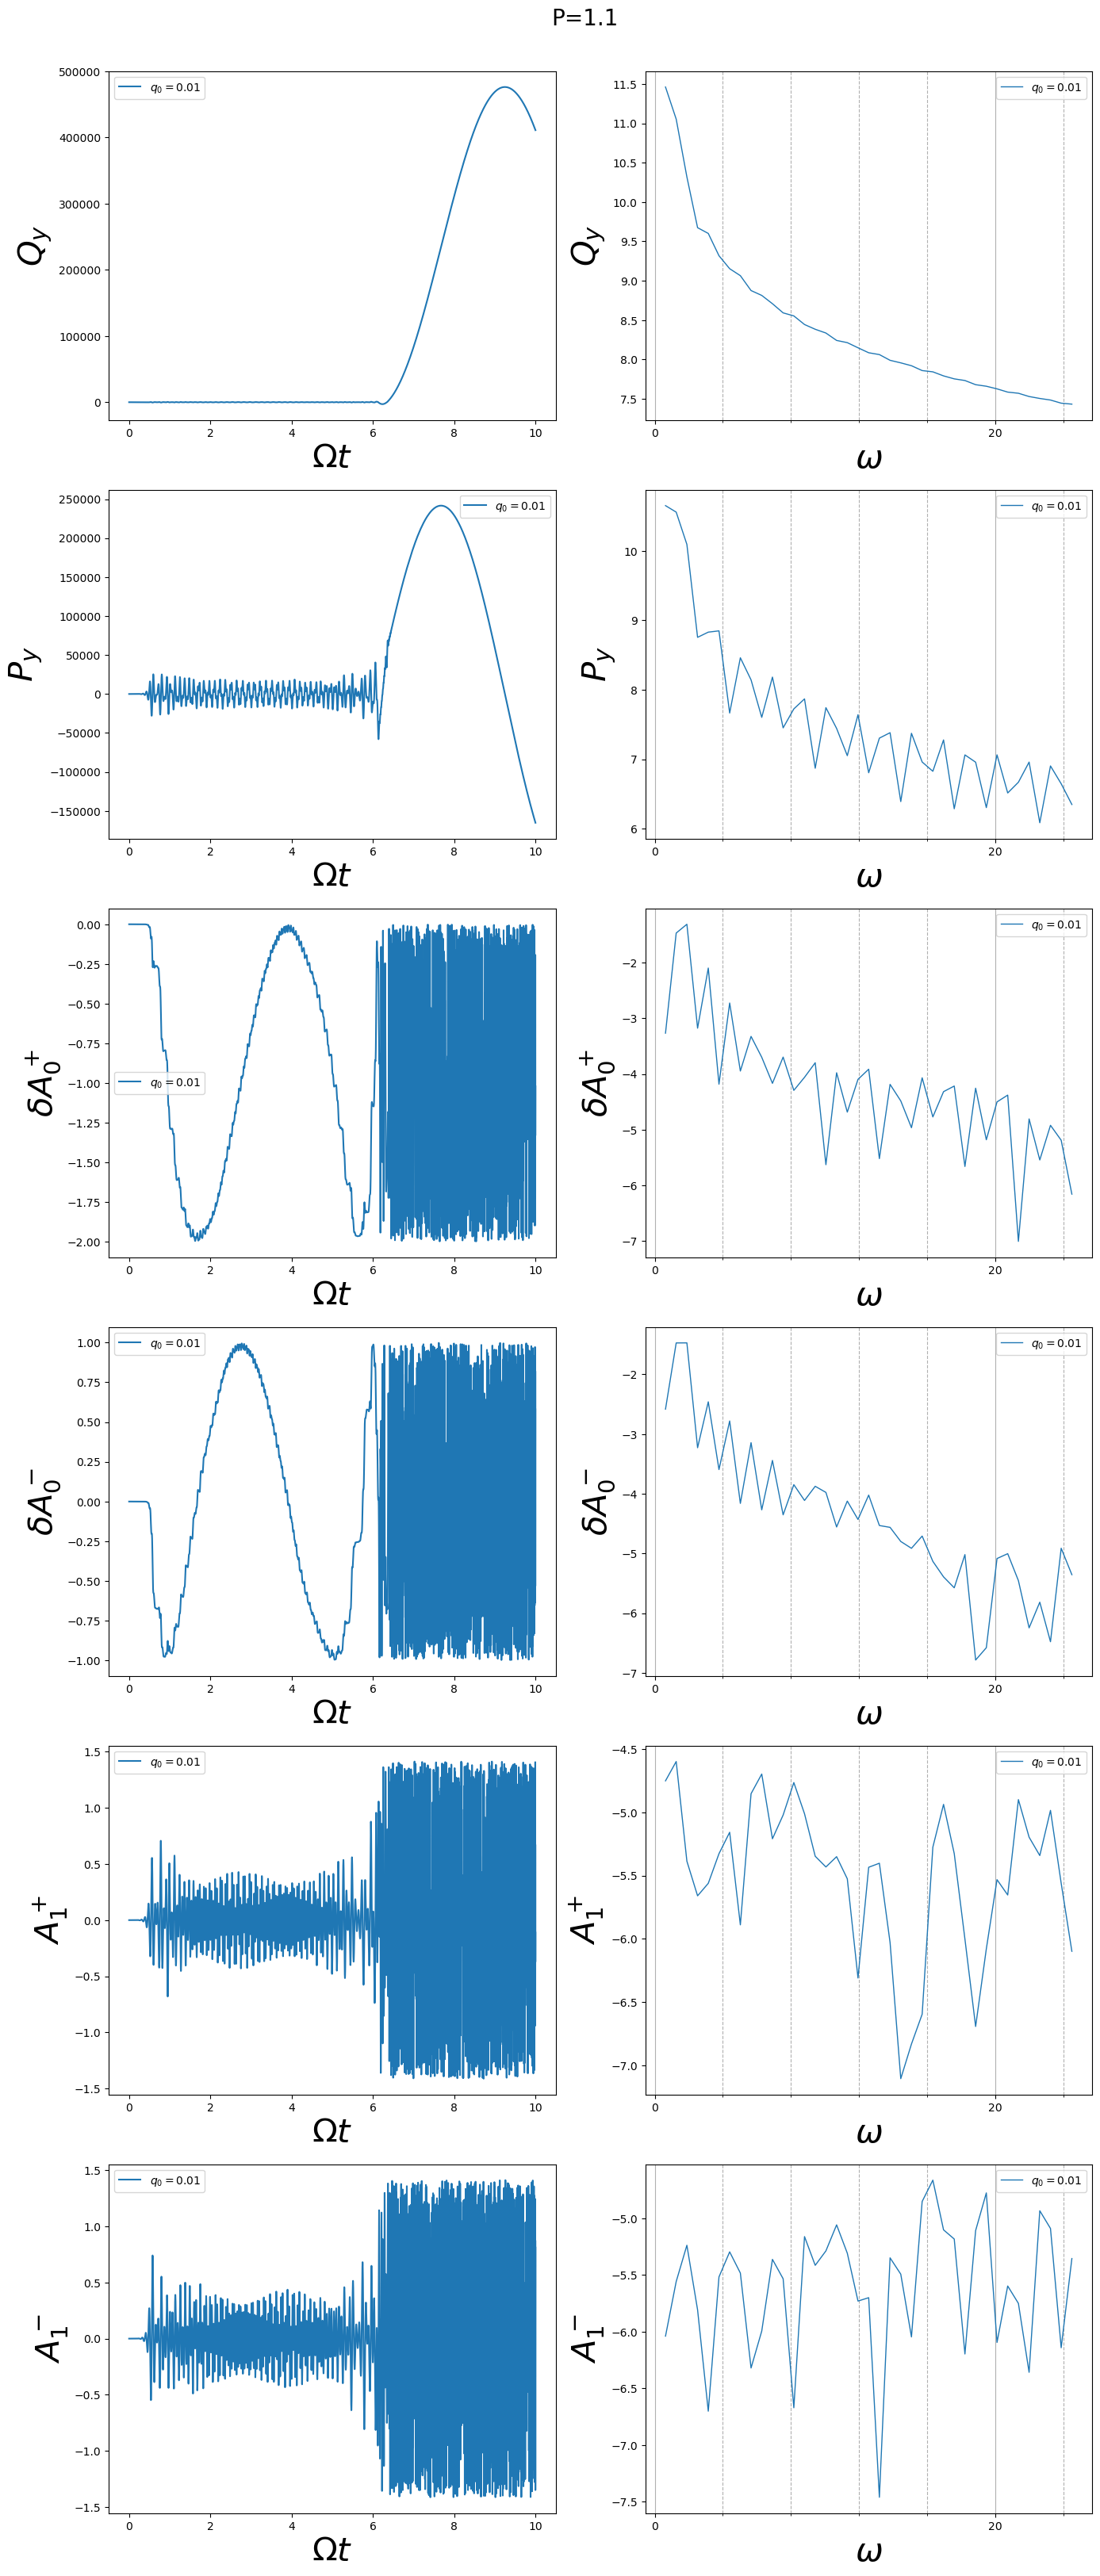

In [13]:
# g_z1=0############ 
P=1.1 ############### CRITICAL parameter
g_y=1e-1
N0=(P*del_omega)**3/(8*g_y**2)
print("N0=",np.round(N0))
# title='$g_y={0}\Omega  \: ; \: N_0={1} \: ; \: P_c={2}$'.format(g_y,N0,P)

label_list=["$Q_z$","$P_z$","$Q_y$","$P_y$","$\delta A_0^+$","$\delta A_0^-$","$A_1^+$","$A_1^-$","$H$","$N$"]
tf=1e1
N_step=10000
qy_0=1e-2
sf,ef=1,40
om=2*np.pi*np.arange(N_step//2+1)[sf:ef]/tf

z_0=np.array([0,0,qy_0,0,0,0,0,0])

param_list=[g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
zz,t=real_evolve(z_0,tf,param_list,N_step,rtol = 1e-6, atol = 1e-6)
label="$q_0={0}$".format(qy_0)
fig, axs = plt.subplots(6, 2,figsize=(16,40))
for i in range(6):
#         axs[i,0].plot(t,zz[i]/qy_0**2,label=label)
    axs[i,0].plot(t,zz[i+2],label=label)
    zff=np.log(np.abs(np.fft.rfft(zz[i+2]))/N_step)
#         zff=(np.abs(np.fft.rfft(zz[i]))/N_step)
    axs[i,1].plot(om,zff[sf:ef],label=label,linewidth=1)
title="P={0}".format(P)
plt.suptitle(title,fontsize=20,y=0.9)

for i in range(6):
    axs[i,0].set_ylabel(label_list[i+2],fontsize=30)
    axs[i,0].set_xlabel('$\Omega t$',fontsize=30)
    axs[i,0].legend()

    axs[i,1].set_ylabel(label_list[i+2],fontsize=30)
    axs[i,1].set_xlabel('$\omega$',fontsize=30)
    axs[i,1].legend()
    axs[i,1].xaxis.set_major_locator(plticker.MultipleLocator(20))
    axs[i,1].xaxis.set_minor_locator(plticker.MultipleLocator(4))
    axs[i,1].grid(axis = 'x',which="major")
    axs[i,1].grid(axis = 'x',which="minor", linestyle='--')
    #     axs[i//2,i%2].legend(fontsize=12)

plt.show() 

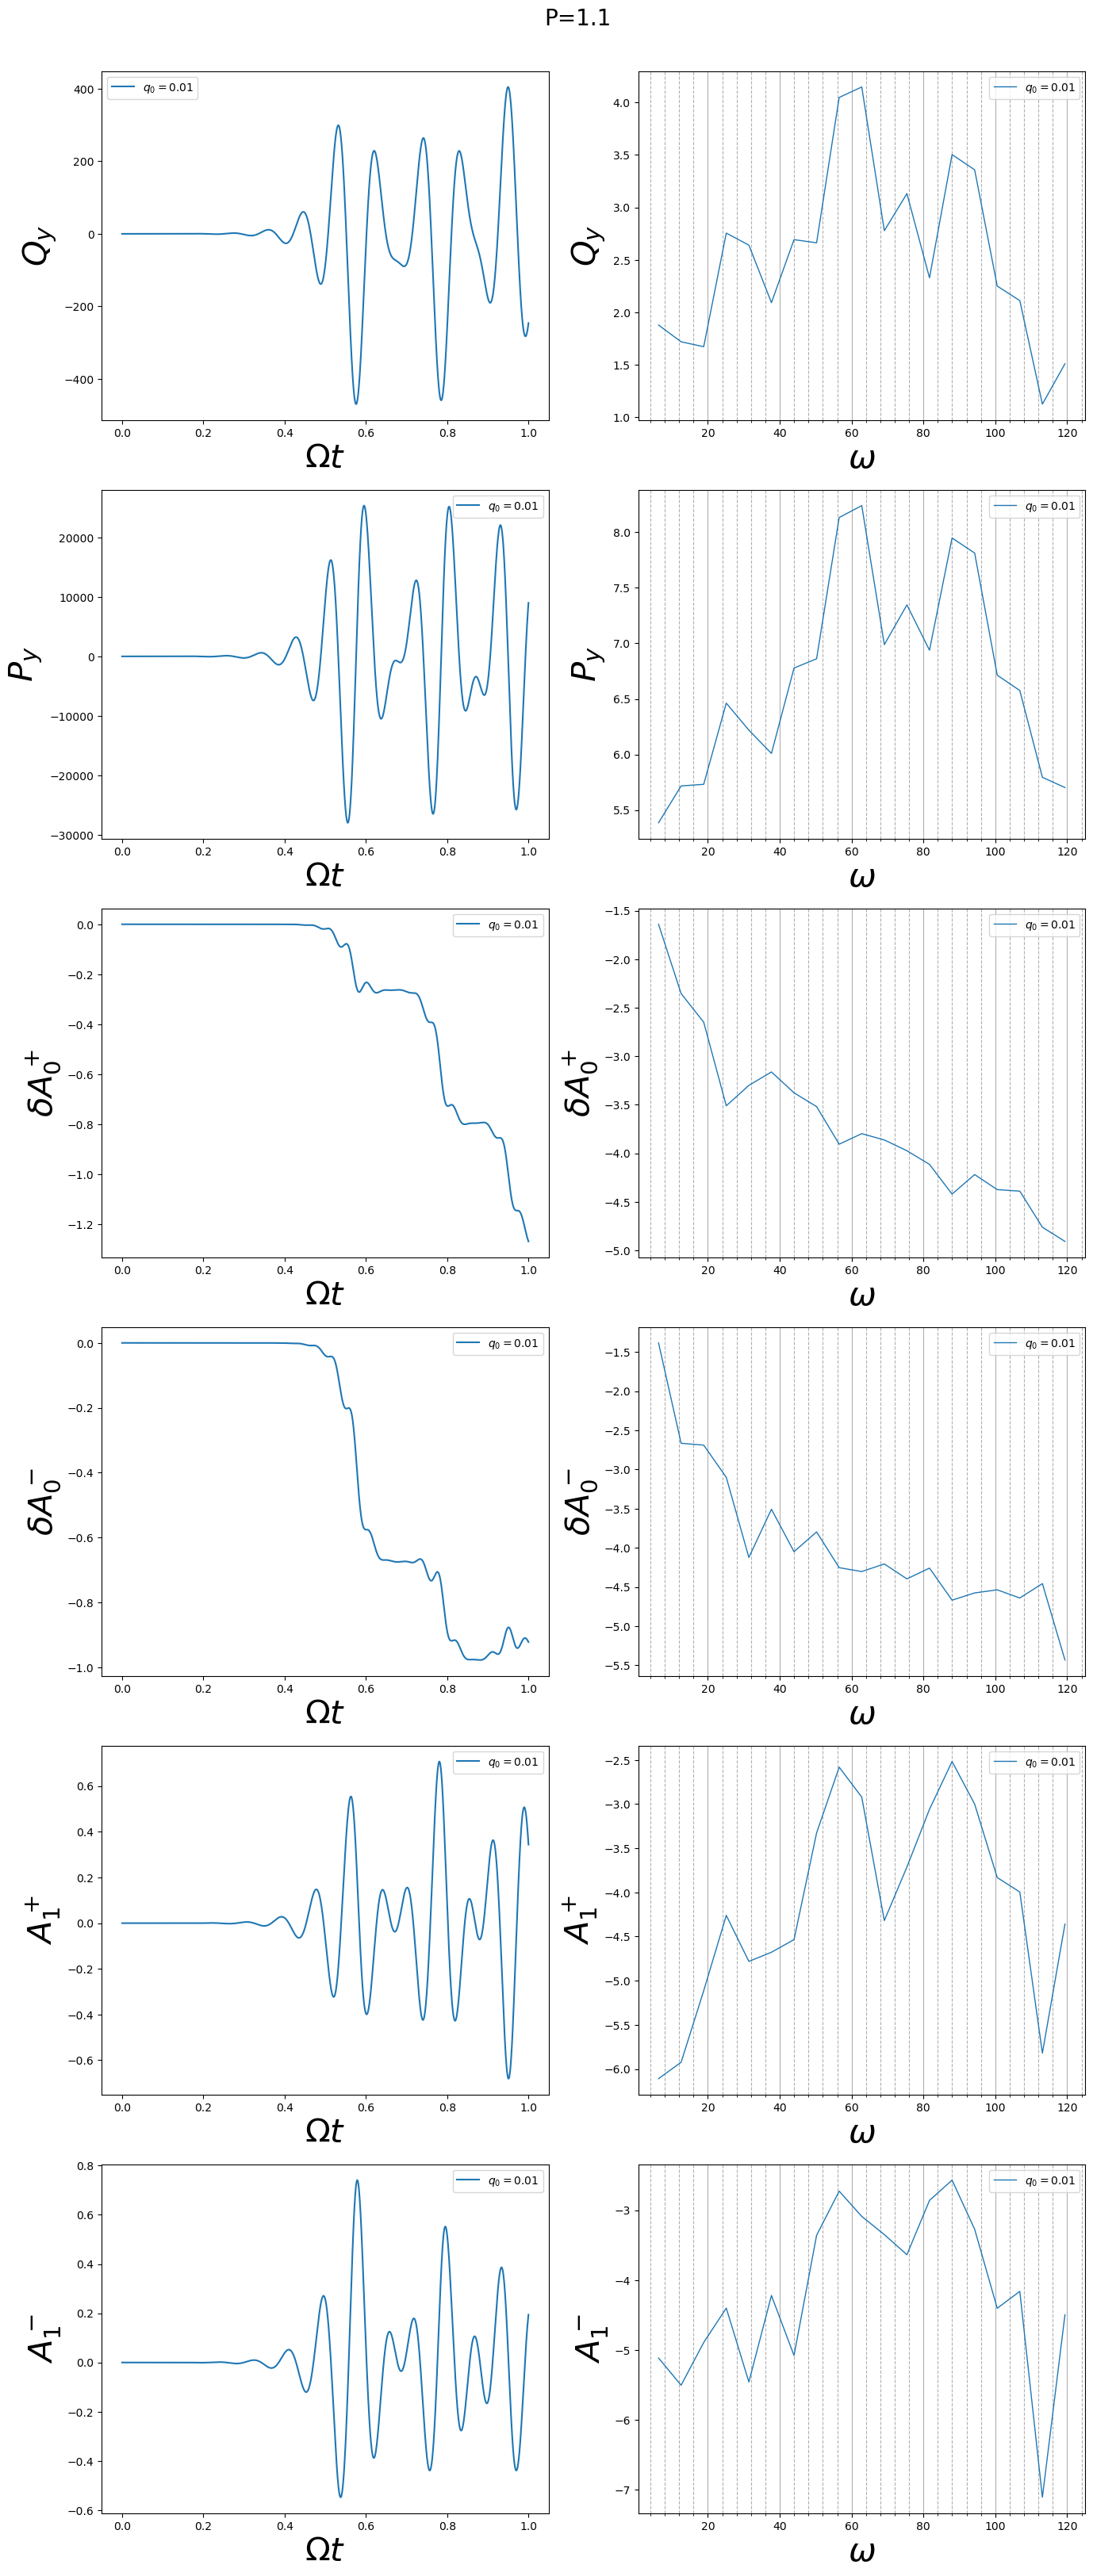

In [11]:
sf,ef=1,20
om=2*np.pi*np.arange(N_step//2+1)[sf:ef]/tf
fig, axs = plt.subplots(6, 2,figsize=(16,40))

for i in range(6):
#         axs[i,0].plot(t,zz[i]/qy_0**2,label=label)
    axs[i,0].plot(t,zz[i+2],label=label)
    zff=np.log(np.abs(np.fft.rfft(zz[i+2]))/N_step)
#         zff=(np.abs(np.fft.rfft(zz[i]))/N_step)
    axs[i,1].plot(om,zff[sf:ef],label=label,linewidth=1)
title="P={0}".format(P)
plt.suptitle(title,fontsize=20,y=0.9)

for i in range(6):
    axs[i,0].set_ylabel(label_list[i+2],fontsize=30)
    axs[i,0].set_xlabel('$\Omega t$',fontsize=30)
    axs[i,0].legend()

    axs[i,1].set_ylabel(label_list[i+2],fontsize=30)
    axs[i,1].set_xlabel('$\omega$',fontsize=30)
    axs[i,1].legend()
    axs[i,1].xaxis.set_major_locator(plticker.MultipleLocator(20))
    axs[i,1].xaxis.set_minor_locator(plticker.MultipleLocator(4))
    axs[i,1].grid(axis = 'x',which="major")
    axs[i,1].grid(axis = 'x',which="minor", linestyle='--')
    #     axs[i//2,i%2].legend(fontsize=12)

plt.show() 